In [1]:
from math import ceil
import re
import subprocess
import sys

import pandas as pd
import pegasus as pg
import numpy as np

import paths
from config import do_counts, do_genes, do_mito, do_ribo, OUTPUT_DIR, DATA_DIR
from filters import filter_cells, initial_qc
from local_config import local
from readers import auto_reader
from utils import cluster_data, safe_mkdir, add_cd_scores, title

TASKS_PER_TISS = 1  # how many different methods per one tissue. Used to determine method and param from task id
#DATA_DIR = "/Users/michaelalperovich/Documents/primes_storage/data/"
DATA_DIR = "/Volumes/easystore/primes_storage/data/"

project = "mc_PanglaoDB"
task_id = 4
res = 1.4

In [2]:
tissue, is_human, adata = auto_reader(project, task_id, TASKS_PER_TISS)  # read the data for current task id
method, param = "mad", 2
adata = initial_qc(adata, 100, 3, is_human)

2020-12-01 20:07:39,999 - pegasusio.text_utils - INFO - Detected mtx file in dropEst or BUStools format.
2020-12-01 20:11:35,918 - pegasusio.readwrite - INFO - mtx file '/Volumes/scqc/data/PanglaoDB/Testis/matrix.mtx' is loaded.
2020-12-01 20:11:35,921 - pegasusio.readwrite - INFO - Function 'read_input' finished in 238.88s.
2020-12-01 20:11:36,149 - pegasusio.aggr_data - INFO - Function 'aggregate' finished in 0.21s.
2020-12-01 20:11:36,175 - pegasusio.data_aggregation - INFO - Aggregated 1 files.
2020-12-01 20:11:36,175 - pegasusio.data_aggregation - INFO - Function 'aggregate_matrices' finished in 239.14s.
2020-12-01 20:11:37,419 - pegasusio.qc_utils - INFO - After filtration, 30408 out of 31341 cell barcodes are kept in UnimodalData object GRCh38-rna.
2020-12-01 20:11:38,347 - pegasus.tools.preprocessing - INFO - After filtration, 48338/48350 genes are kept. Among 48338 genes, 32323 genes are robust.


In [3]:
#task_directory = str(res) + "-" + method + "-" + str(param)
task_directory = "filtered_cells_plots/no_outlier/"
results_dir = "/Users/michaelalperovich/Documents/primes_storage/output_pg/" + project + "/" + tissue + "/" + task_directory + "/"  # directory for saving output
cells = pd.read_csv(results_dir + "!cells.csv")
clusters = pd.read_csv(results_dir + "!clusters.csv")

adata.obs["is_mad2"] = False
adata.obs["is_mad2"][cells["barcodekey"]] = True
adata.obs["passed_qc"] = (adata.obs.is_mad2)
pg.filter_data(adata)

<ipython-input-3-fa1fccc8798b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["is_mad2"][cells["barcodekey"]] = True


2020-12-01 20:11:38,864 - pegasusio.qc_utils - INFO - After filtration, 27197 out of 30408 cell barcodes are kept in UnimodalData object GRCh38-rna.


In [32]:
cells.louvain_labels = [t - 1 for t in cells.louvain_labels]
cells = cells.reindex(adata.obs.index)
adata.obs["louvain_labels"] = cells.louvain_labels
adata.obs["clusters"] = [int(t) for t in adata.obs["louvain_labels"]]
x_umap = np.array([[cells.umap1[i], cells.umap2[i]] for i in range(len(cells.umap1))], dtype="float32")
adata.obsm["X_umap"] = x_umap


In [5]:
pg.run_scrublet(adata)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.37
Detected doublet rate = 3.3%
Estimated detectable doublet fraction = 33.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.8%
Elapsed time: 80.8 seconds
2020-12-01 20:13:02,685 - pegasus.tools.doublet_detection - INFO - Scrublet is finished.
2020-12-01 20:13:02,896 - pegasus.tools.doublet_detection - INFO - Function 'run_scrublet' finished in 82.74s.


In [6]:
adata

MultimodalData object with 1 UnimodalData: 'GRCh38-rna'
    It currently binds to UnimodalData object GRCh38-rna

UnimodalData object with n_obs x n_vars = 27197 x 48338
    Genome: GRCh38; Modality: rna
    It contains 1 matrices: 'X'
    It currently binds to matrix 'X' as X

    obs: 'Channel', 'annotations', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'is_mad2', 'scrublet_score'
    var: 'n_cells', 'percent_cells', 'robust', 'highly_variable_features'
    obsm: 'X_umap'
    varm: 
    uns: 'genome', 'modality', 'scrublet_stats'

In [7]:
adata.obs.scrublet_score

barcodekey
Testis-SRA826293_SRS4181128.sparse.RData_AAACCTGAGAATGTGT    0.240593
Testis-SRA826293_SRS4181128.sparse.RData_AAACCTGAGAGAGCTC    0.084746
Testis-SRA826293_SRS4181128.sparse.RData_AAACCTGAGCTAGCCC    0.049505
Testis-SRA826293_SRS4181128.sparse.RData_AAACCTGCAAATACAG    0.084746
Testis-SRA826293_SRS4181128.sparse.RData_AAACCTGCAAGTTCTG    0.163145
                                                               ...   
Testis-SRA826293_SRS4181130.sparse.RData_TTTGTCATCCCTCTTT    0.087465
Testis-SRA826293_SRS4181130.sparse.RData_TTTGTCATCCTCATTA    0.219048
Testis-SRA826293_SRS4181130.sparse.RData_TTTGTCATCGCTTAGA    0.058561
Testis-SRA826293_SRS4181130.sparse.RData_TTTGTCATCTGAGTGT    0.209397
Testis-SRA826293_SRS4181130.sparse.RData_TTTTTTTTTTTTTTTT    0.303867
Name: scrublet_score, Length: 27197, dtype: float64

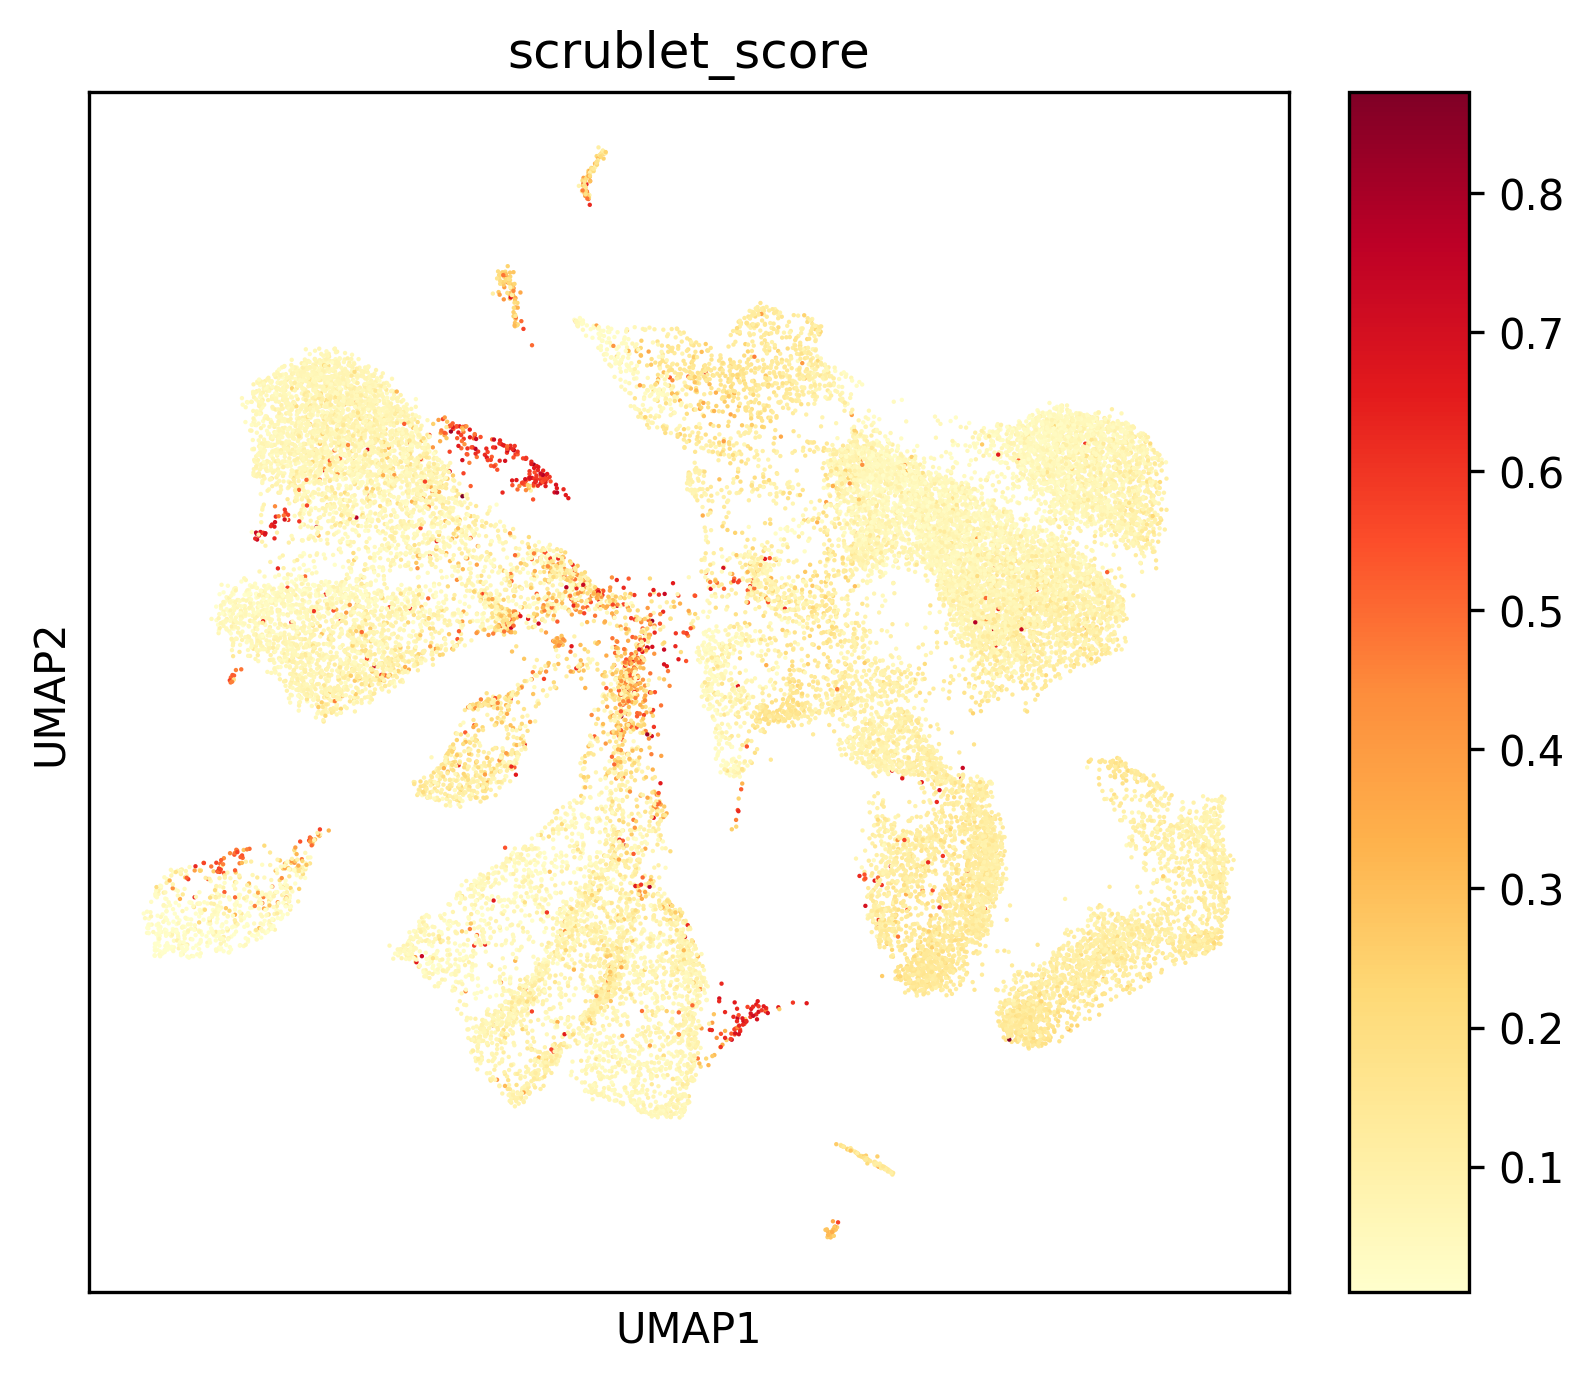

In [8]:
pg.scatter(adata, attrs="scrublet_score", basis='umap')

In [39]:
adata_copy = adata.to_anndata().copy()
mad_only_cells = adata_copy[adata_copy.obs.color == "MAD2 only"]
mad_only_cells.obs["filtered_by_ngenes"] = False
mad_only_cells.obs["filtered_by_mito"] = False

Trying to set attribute `.obs` of view, copying.


In [19]:
mad_only_cells.obs.loc[mad_only_cells.obs.n_genes < 200, "filtered_by_ngenes"] = True
mad_only_cells.obs.loc[mad_only_cells.obs.percent_mito > 10, "filtered_by_mito"] = True

In [20]:
mad_only_cells[mad_only_cells.obs.filtered_by_ngenes == True]

View of AnnData object with n_obs × n_vars = 1068 × 48338 
    obs: 'Channel', 'annotations', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'is_mad2', 'scrublet_score', 'color', 'louvain_labels', 'clusters', 'filtered_by_ngenes', 'filtered_by_mito'
    var: 'n_cells', 'percent_cells', 'robust', 'highly_variable_features'
    uns: 'genome', 'modality', 'scrublet_stats'
    obsm: 'X_umap'

In [21]:
mad_only_cells[mad_only_cells.obs.filtered_by_mito == True]

View of AnnData object with n_obs × n_vars = 10646 × 48338 
    obs: 'Channel', 'annotations', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'is_mad2', 'scrublet_score', 'color', 'louvain_labels', 'clusters', 'filtered_by_ngenes', 'filtered_by_mito'
    var: 'n_cells', 'percent_cells', 'robust', 'highly_variable_features'
    uns: 'genome', 'modality', 'scrublet_stats'
    obsm: 'X_umap'

In [22]:
print(len(mad_only_cells[mad_only_cells.obs.scrublet_score > 0.5].obs.color))
mad_only_cells[mad_only_cells.obs.scrublet_score > 0.5].obs

186


,Channel,annotations,n_genes,n_counts,percent_mito,percent_ribo,is_mad2,scrublet_score,color,louvain_labels,clusters,filtered_by_ngenes,filtered_by_mito
barcodekey,,,,,,,,,,,,,
Testis-SRA826293_SRS4181128.sparse.RData_AAACCTGGTAACGTTC,Testis,Unknown,367,577,11.091854,4.159445,True,0.544828,MAD2 only,13,13,False,True
Testis-SRA826293_SRS4181128.sparse.RData_AAAGCAAAGCGCTCCA,Testis,Unknown,679,1030,18.737864,5.339806,True,0.656676,MAD2 only,13,13,False,True
Testis-SRA826293_SRS4181128.sparse.RData_ACGGAGATCCAATGGT,Testis,Unknown,361,630,29.206349,3.333333,True,0.691429,MAD2 only,13,13,False,True
Testis-SRA826293_SRS4181128.sparse.RData_AGCAGCCTCCTAGAAC,Testis,Unknown,493,661,18.003026,3.328290,True,0.522124,MAD2 only,3,3,False,True
Testis-SRA826293_SRS4181128.sparse.RData_AGTGAGGAGACAAAGG,Testis,Unknown,3776,10238,10.109396,17.151787,True,0.544828,MAD2 only,15,15,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Testis-SRA826293_SRS4181130.sparse.RData_TGTGGTAAGGGCTCTC,Testis,Unknown,4034,9506,10.077846,9.341469,True,0.501066,MAD2 only,17,17,False,True
Testis-SRA826293_SRS4181130.sparse.RData_TGTGTTTGTTCAGGCC,Testis,Unknown,1528,2178,11.570248,3.076217,True,0.522124,MAD2 only,1,1,False,True
Testis-SRA826293_SRS4181130.sparse.RData_TTAACTCCACATCTTT,Testis,Unknown,2553,5144,11.430793,9.389580,True,0.569378,MAD2 only,19,19,False,True


In [23]:
mad_only_cells[(mad_only_cells.obs.scrublet_score > 0.5) & (mad_only_cells.obs.filtered_by_ngenes == True)]

View of AnnData object with n_obs × n_vars = 38 × 48338 
    obs: 'Channel', 'annotations', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'is_mad2', 'scrublet_score', 'color', 'louvain_labels', 'clusters', 'filtered_by_ngenes', 'filtered_by_mito'
    var: 'n_cells', 'percent_cells', 'robust', 'highly_variable_features'
    uns: 'genome', 'modality', 'scrublet_stats'
    obsm: 'X_umap'

In [24]:
mad_only_cells[(mad_only_cells.obs.scrublet_score > 0.5) & (mad_only_cells.obs.filtered_by_mito == True)]

View of AnnData object with n_obs × n_vars = 176 × 48338 
    obs: 'Channel', 'annotations', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'is_mad2', 'scrublet_score', 'color', 'louvain_labels', 'clusters', 'filtered_by_ngenes', 'filtered_by_mito'
    var: 'n_cells', 'percent_cells', 'robust', 'highly_variable_features'
    uns: 'genome', 'modality', 'scrublet_stats'
    obsm: 'X_umap'

Trying to set attribute `.obs` of view, copying.


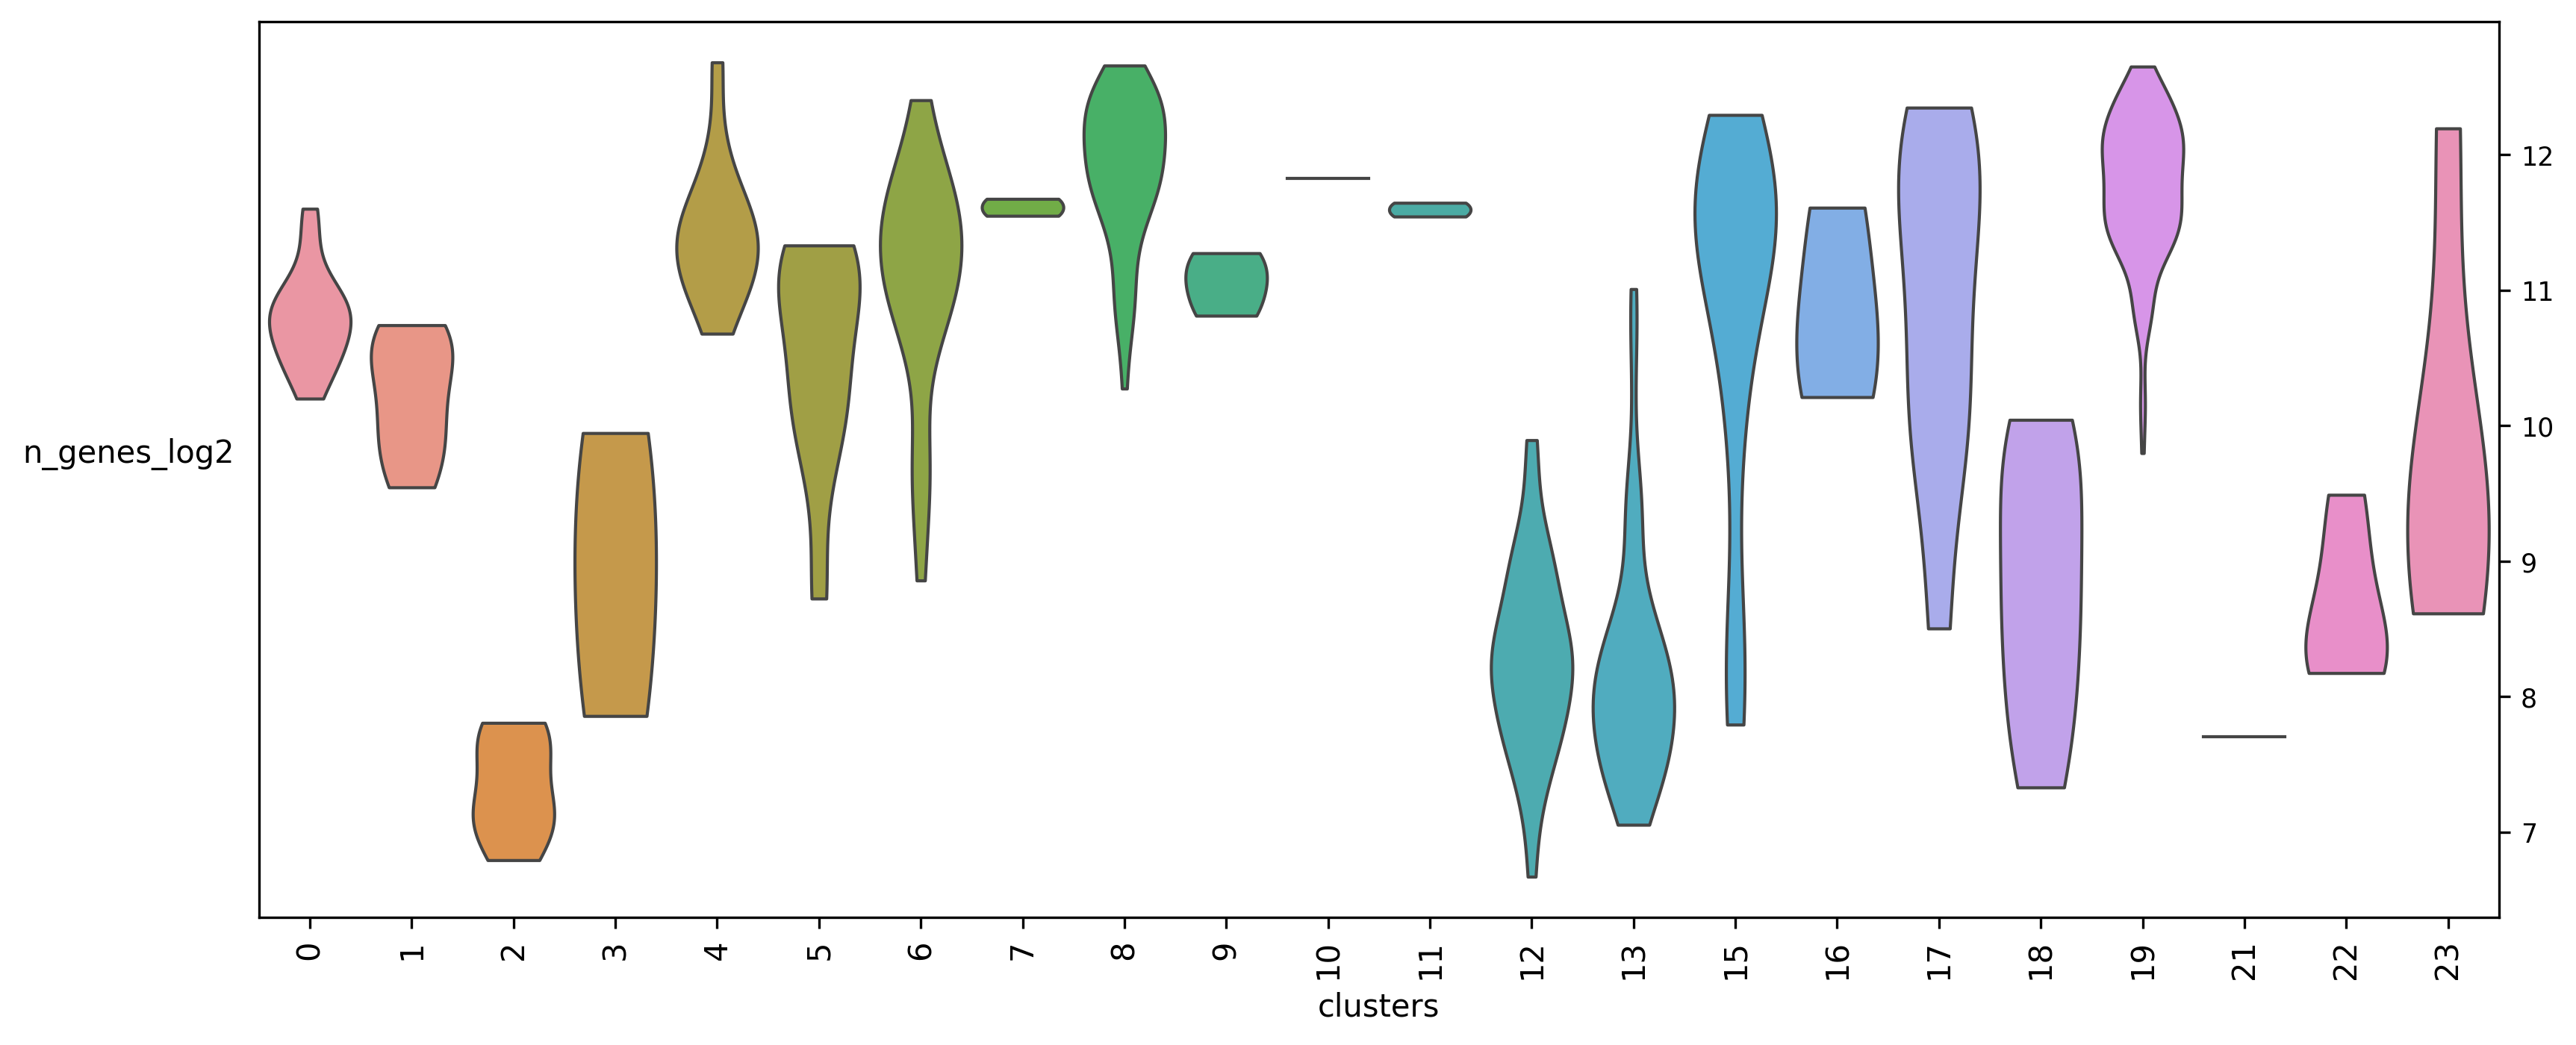

In [42]:
from math import log2

high_scrublet_cells = adata_copy[adata_copy.obs.scrublet_score > 0.5]
high_scrublet_cells.obs["n_genes_log2"] = np.log2(high_scrublet_cells.obs.n_genes)
pg.violin(high_scrublet_cells, attrs="n_genes_log2", groupby='clusters', panel_size=(10, 4))

In [37]:
np.median(adata[adata.obs.scrublet_score > 0.5].obs.n_genes)

2188.0